# Invest $10,000
## Which Stock Will YOU Choose?

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def loadData(code="AAPL", startDate="2023-01-01", endDate="2024-01-01"):
    if startDate > endDate:
        print("Start Date must be before End Date!")
        return None

    startDate = datetime.strptime(startDate, "%Y-%m-%d")
    startDate = startDate - timedelta(days=20)#subtract days to adjust for sma delay
    startDate = startDate.strftime("%Y-%m-%d")

    stock = yf.download(code, start=startDate, end=endDate, progress=False, threads=False)

    print(stock.columns)# testing

    if isinstance(stock.columns, pd.MultiIndex):
        stock.columns = stock.columns.droplevel(1)

    if 'Close' not in stock.columns:
        print("Error: 'Close' column is missing. Check the ticker symbol.")
        print(stock.head())
        return None
    stock = stock[["Close"]]
    print(stock.head(2))

    if stock.empty:
        print(f"No data found for '{code}'. Check the stock code and date range.")
        return None

    return stock


In [13]:


print("...")
print("This strategy uses 20 Day Simple Moving Average.")
print("When current closing price SMA_20 (red), you buy $10,000 worth")
print("And when current closing price gets overtaken by SMA_20, you sell all for cash")# turn into markdown cells not print lol

def signals(stock):
  stock["SMA_20"] = stock["Close"].rolling(window=20).mean()
  return stock

def backtest(stock, currentCash=1000, transactionFee=0.001):
  currentStocksBought = 0
  currentValue = currentCash
  buys = 0
  sells = 0

  holdCash = currentCash
  holdStocksBought = 0
  holdValue = 0
  holding = False

  for date, row in stock.iterrows():
    if pd.isna(row["SMA_20"]) or pd.isna(row["Close"]):
      continue

    currentPrice = row["Close"]

    # passive strategy
    holdValue = holdStocksBought * currentPrice
    stock.loc[date, "Hold_Value"] = holdValue

    # Trading strategy
    sma20 = row["SMA_20"]

    if holding == False:
      holdStocksBought = holdCash / currentPrice
      holdCash = 0
      stock.loc[date, "Hold_Value"] = holdStocksBought * currentPrice
      holding = True

    if currentPrice > sma20:
      if currentCash > 0: # buy
        currentCash -= currentCash * transactionFee
        currentStocksBought = currentCash / currentPrice
        currentCash = 0
        buys += 1
    else:
      if currentStocksBought > 0: # sell
        value = currentStocksBought * currentPrice
        currentCash = value * (1 - transactionFee)
        currentStocksBought = 0
        sells += 1

    assetsValue = currentStocksBought * currentPrice
    currentValue = assetsValue + currentCash
    stock.loc[date, "Portfolio_Value"] = currentValue

    #print(str(currentValue) + " = " + str(currentPrice) + " * " + str(currentStocksBought) + " + " + str(currentCash))

  # make sure correct data type
  stock["Portfolio_Value"] = stock["Portfolio_Value"].astype(float)
  stock["Hold_Value"] = stock["Hold_Value"].astype(float)
  print(f"Final portfolio value: ${currentValue:.2f}")
  print(f"Hypothetical hold value: ${holdValue:.2f}")

  return stock

...
This strategy uses 20 Day Simple Moving Average.
When current closing price SMA_20 (red), you buy $10,000 worth
And when current closing price gets overtaken by SMA_20, you sell all for cash


In [14]:
def graph(stock, code="AAPL"):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # plot first y-axis
    ax1.plot(stock.index, stock["Close"], label=code + " Price", color="blue")
    ax1.plot(stock.index, stock["SMA_20"], label=code + " 20-Day SMA", linestyle="--", color="red")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price (USD)")
    ax1.legend(loc="upper left") # legend is the label
    ax1.grid(True)

    # second y axis
    ax2 = ax1.twinx()
    ax2.plot(stock.index, stock["Portfolio_Value"], label="Portfolio Value", color="cyan")
    ax2.plot(stock.index, stock["Hold_Value"], label="Hold Value", color="yellow")
    ax2.set_ylabel("Portfolio Value (USD)")
    ax2.legend(loc="upper right")


    plt.title(code + " Strategy vs Hold Comparison")
    plt.show()

/tmp/ipython-input-5-1456353043.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(code, start=startDate, end=endDate, progress=False, threads=False)


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price            Close
Date                  
2022-12-12  142.642258
2022-12-13  143.609741
1000.0 = 129.0582275390625 * 0 + 1000
999.0 = 131.78297424316406 * 7.580645419010345 + 0
998.4010531314142 = 131.70396423339844 * 7.580645419010345 + 0
1008.504030612298 = 133.0366973876953 * 7.580645419010345 + 0
1017.3347376011822 = 134.20159912109375 * 7.580645419010345 + 0
1011.8716897725926 = 133.48094177246094 * 7.580645419010345 + 0
1012.3207264168278 = 133.54017639160156 * 7.580645419010345 + 0
1031.7784026430063 = 136.10693359375 * 7.580645419010345 + 0
1056.02580307436 = 139.30552673339844 * 7.580645419010345 + 0
1066.6521939543072 = 140.70730590820312 * 7.580645419010345 + 0
1061.6382984414224 = 140.0458984375 * 7.580645419010345 + 0
1077.3543496467157 = 142.11907958984375 * 7.580645419010

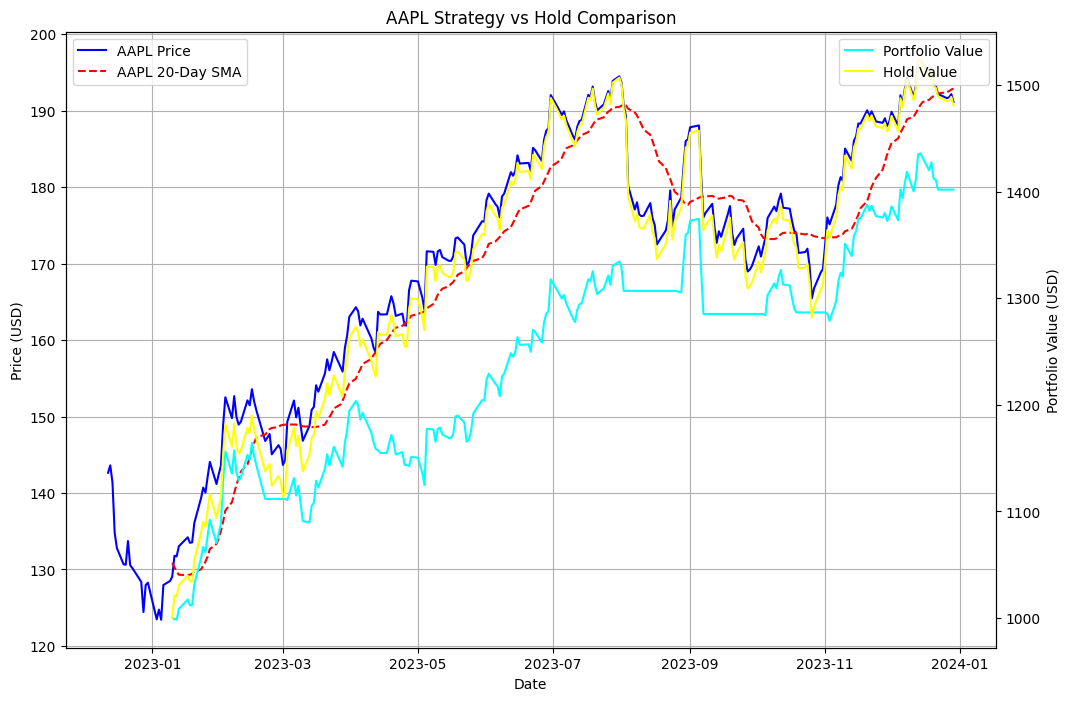

In [15]:
data = loadData()
data = signals(data)
data = backtest(data)
graph(data)
